In [1]:
library(edgeR)
library(magrittr)
library(ggplot2)
#library(DESeq2)
library(MAST)
library(tidyr)
library(dplyr)
library(reshape)
library(Seurat)
#library(SeuratDisk)
require(scales)
library(gplots)
library(reshape2)
library(sceasy)
library(reticulate)

Loading required package: limma

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, row

In [3]:
h5ad_file <- "/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/Stroma_integration_raw_no_nan.h5ad"

sceasy::convertFormat(h5ad_file, from="anndata", to="seurat",
                      outFile='/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/Stroma_integration_raw_no_nan.rds')

X -> counts



An object of class Seurat 
33538 features across 373583 samples within 1 assay 
Active assay: RNA (33538 features, 0 variable features)

In [2]:
pseudobulk <- function(seurat_object, column, label){
    seurat_object@meta.data[,column] <- as.character(seurat_object@meta.data[,column])
    tmp <- seurat_object[,seurat_object@meta.data[,column]==label]
    tmp2 <- Matrix::rowSums(tmp@assays$RNA@counts)
    return(tmp2)
}

### column -- donor_id
### label -- each donor
### raw counts

In [3]:
sdata <- readRDS("/lustre/scratch117/cellgen/team205/rl20/CTCL/object-new/Stroma_integration_raw_no_nan.rds")

In [4]:
sdata <- subset(sdata, cells = 
               rownames(sdata@meta.data)[which(sdata$Site_condition == 'Healthy_non_lesion' |
                                               sdata$Site_condition == 'CTCL_lesion' |
                                               sdata$Site_condition == 'AD_lesion' |
                                               sdata$Site_condition == 'Psoriasis_lesion')]) ### lesional only

In [5]:
table(sdata$broad_cell_type)


    V-Endo         KC      Fibro   Pericyte Melanocyte     L-Endo 
     54618     122374      63349      22197      10451       8840 

In [6]:
Target_cell <- 'Fibro'
Target_subset <- subset(sdata,  cells = 
                 rownames(sdata@meta.data)[which(sdata$broad_cell_type == Target_cell)])

In [78]:
#Target_subset <- NormalizeData(Target_subset, normalization.method = "LogNormalize", scale.factor = 10000)
#Target_subset <- FindVariableFeatures(Target_subset, selection.method = "vst")

In [79]:
#length(VariableFeatures(object = Target_subset))

In [7]:
mat <- c()
coln <- c()
for (name in as.vector(sort(unique(Target_subset$donor_id)))) {
     pp <- pseudobulk(Target_subset, 'donor_id', name)
     mat <- cbind(mat, pp)
     coln <- c(coln, name)
} 
colnames(mat) <- coln
rownames(mat) <- rownames(Target_subset@assays$RNA@counts)
#mat <- mat[VariableFeatures(object = Target_subset), ]
dim(mat)

[1] 33538    20

In [8]:
Condition <- "CTCL" #### Physiological conditions

control <- as.vector(unique(Target_subset$donor_id
                            [which(Target_subset$integrated_sample_id != Condition)]))
mut <- as.vector(unique(Target_subset$donor_id
                        [which(Target_subset$integrated_sample_id == Condition)]))
sub <- c(control, mut)
mat_sub <- mat[, sub]
groups <- factor(c(rep(1, length(control)), rep(2, length(mut))))

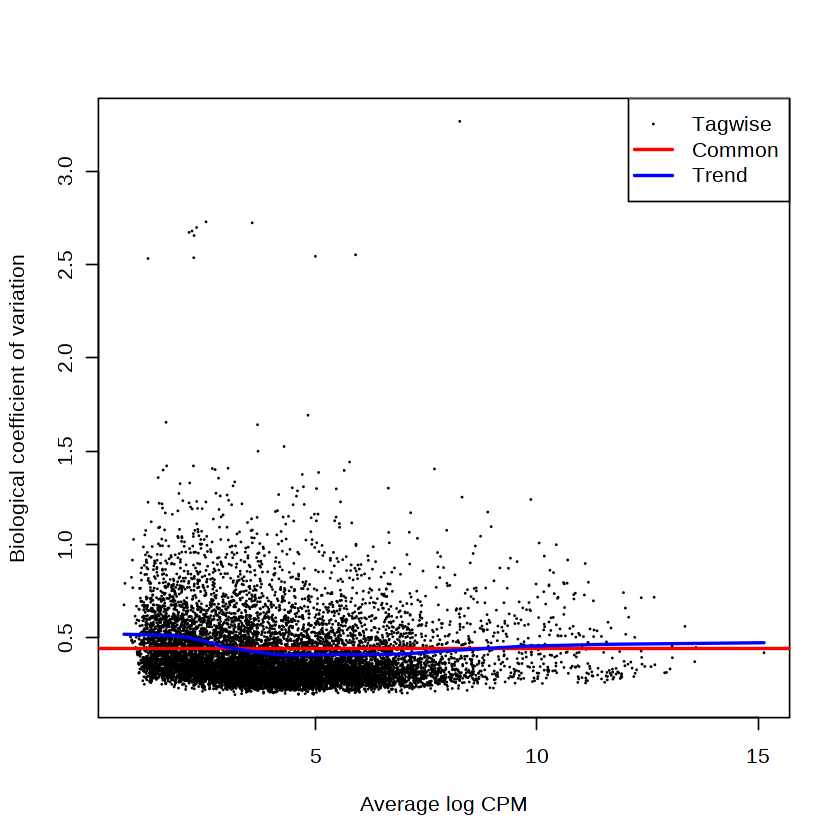

In [9]:
#########edgeR#########
DEGs <- DGEList(counts=mat_sub, group=groups)

keep <- filterByExpr(DEGs, min.count=50, min.total.count=100)
DEGs <- DEGs[keep, , keep.lib.sizes=FALSE]

DEGs <- calcNormFactors(DEGs)

#cdr <- scale(colMeans(mat_sub > 0))
#design <- model.matrix(~cdr+groups)
design <- model.matrix(~groups)

DEGs <- estimateDisp(DEGs, design = design)
fit <- glmQLFit(DEGs, design = design)
qlf <- glmQLFTest(fit,coef=2)
tt <- topTags(qlf, n = Inf)
plotBCV(DEGs)

et <- exactTest(DEGs)
et_FDR <- topTags(et, n = nrow(et$table), adjust.method = "BH", sort.by = "PValue", p.value = 1)

out_temp <- et_FDR$table

In [10]:
#out_temp
edge_mut_up <- out_temp[which(out_temp$FDR<0.01 & out_temp$logFC>0), ]

In [11]:
edge_mut_up

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
MEI1,2.7090257,2.137083,1.252453e-10,7.184069e-07
HYOU1,1.8030414,6.168549,6.357396e-10,1.823301e-06
CCL5,3.0958047,5.561395,1.213424e-09,2.784080e-06
C9orf116,1.7097038,1.874876,1.658770e-09,2.996446e-06
MTRNR2L12,5.5433699,9.864702,1.828375e-09,2.996446e-06
PCSK1,2.2023826,3.691861,8.175210e-09,8.526001e-06
JAK3,1.3889597,2.565772,1.695635e-08,1.621027e-05
MDK,1.8262739,6.222871,2.282813e-08,1.869713e-05
FICD,1.7556096,4.071028,4.062001e-08,2.588849e-05
